In [17]:
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
REVIEWS_DATASET_DIR = '../../dataset'
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_use]

In [3]:
review_df.head(1)

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review
0,0,2209612,953596359,Besides elegant grand palace and wat pra kaew ...,"The place is nearby grand palace, in the area ...",Family,5,Wat Ratchabophit,Bangkok,P03013220,joy,besides elegant grand palace <OOV> wat pra kae...


In [4]:
import sys
import os

# Define the path to the parent directory where `utils` is located
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Add the parent directory to the Python path
sys.path.append(parent_directory)

# Verify the updated path
print("Updated sys.path:", sys.path)

Updated sys.path: ['/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages', '/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/setuptools/_vendor', '/Users/ittichaiboonyarakthunya/Documents/WorkDir/developments/IS_Project_Thailand_Tourism_Recommendation']


In [5]:
import sys
import os

# Set the path to the parent directory relative to where the notebook is located
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../utils')))

In [7]:
from utils.data_preparation import DataPreparation

DP = DataPreparation()
DP.check_nltk_path()


True


In [8]:

review_df['cleaned_review'] = review_df['review'].apply(DP.clean_text)

sentences = [row.split() for row in review_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300

/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_4420/3405331118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['cleaned_review'] = review_df['review'].apply(DP.clean_text)


In [9]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 100  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [12]:
review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: DP.text_to_word2vec(x, word2vec_model))
review_df['sentiment'] = review_df['rating'].apply(DP.map_rating_to_sentiment)

/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_4420/2921404256.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: DP.text_to_word2vec(x, word2vec_model))
/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_4420/2921404256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['sentiment'] = review_df['rating'].apply(DP.map_rating_to_sentiment)


In [13]:
from sklearn.utils import resample

# Assuming `review_df` is your original DataFrame with a 'sentiment' column

# 1. Separate the data by class
df_positive = review_df[review_df.sentiment == 'positive']
df_neutral = review_df[review_df.sentiment == 'neutral']
df_negative = review_df[review_df.sentiment == 'negative']

# 2. Resample the minority classes
# For example, oversample the neutral and negative classes to match the positive class
df_neutral_upsampled = resample(df_neutral,
                                replace=True,  # Sample with replacement
                                n_samples=len(df_positive),  # Match number of positive class samples
                                random_state=42)  # Reproducible results

df_negative_upsampled = resample(df_negative,
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_positive),  # Match number of positive class samples
                                 random_state=42)  # Reproducible results

# 3. Combine the resampled DataFrames
df_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# 4. Shuffle the combined DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 5. Check the distribution of the classes
print(df_balanced['sentiment'].value_counts())


sentiment
neutral     2871
positive    2871
negative    2871
Name: count, dtype: int64


In [15]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [44]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
# X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [19]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (6890, 100)
y_train shape: (6890,)
X_test shape: (1723, 100)
y_test shape: (1723,)


In [20]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [47]:
def load_svn_model(model_path):
    with open(model_path, 'rb') as file:
        return pickle.load(file)

def load_keras_model(model_path):
    return load_model(model_path)


In [55]:
# Define K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [65]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, hinge_loss, precision_recall_fscore_support


In [66]:

SAVED_MODEL_DIR = '../../models'
history_data = {
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': []
}

# Define a function to evaluate a model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    if model_name in ["GRU", "CNN", "Hybrid-CNN-LSTM", "LSTM"]:
        # For deep learning models
        history = model.fit(
            X_train, y_train,
            epochs=2,
            batch_size=64,
            validation_data=(X_val, y_val),
            verbose=1
        )
        
        # Collect training and validation accuracy/loss from history
        history_data['train_accuracy'].append(history.history['accuracy'])
        history_data['val_accuracy'].append(history.history['val_accuracy'])
        history_data['train_loss'].append(history.history['loss'])
        history_data['val_loss'].append(history.history['val_loss'])
        
        # Predict and calculate metrics
        y_pred = np.argmax(model.predict(X_val), axis=1)
    
    else:
        # For non-deep learning models like SVN
        model.fit(X_train, y_train)  # Train the model
        
        # SVN does not track history, so we'll append None for accuracy/loss
        history_data['train_accuracy'].append(None)
        history_data['val_accuracy'].append(None)
        history_data['train_loss'].append(None)
        history_data['val_loss'].append(None)
    # Predict and evaluate
    y_pred = model.predict(X_val)

    # Handling for different model types
    if model_name in ["GRU", "CNN", "Hybrid-CNN-LSTM", "LSTM"]:
        y_pred = np.argmax(y_pred, axis=1)  # Assuming classification task for deep learning models

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='macro', zero_division=1)

    return accuracy, precision, recall, f1

In [67]:
# Paths to your models
model_paths = {
    "SVN": f"{SAVED_MODEL_DIR}/SVN_model_sample.pkl",
    "GRU": f"{SAVED_MODEL_DIR}/GRU_models_sample.keras",
    "CNN": f"{SAVED_MODEL_DIR}/CNN_models_sample.keras",
    "Hybrid-CNN-LSTM": f"{SAVED_MODEL_DIR}/Hybrid-CNN-LSTM_models_sample.keras",
    "LSTM": f"{SAVED_MODEL_DIR}/LSTM_models_sample.keras",
}

# สร้างตัวแปร results หนึ่งครั้งสำหรับเก็บผลลัพธ์ของโมเดลทุกตัว
results = {model_name: {"accuracy": [], "precision": [], "recall": [], "f1": []} for model_name in model_paths}

models = list(model_paths.items())

# Perform K-Fold Cross-Validation
for fold_index, (train_index, val_index) in enumerate(kf.split(X)):
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model_name, model_path = models[fold_index % len(models)]  # เลือกโมเดลตาม fold

    print(f" ======================== Evaluating model {model_name} in fold {fold_index + 1} ======================== ")
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Load the selected model
    if model_name != "SVN":
        model = load_keras_model(model_path)
    else:
        model = load_svn_model(model_path)

    # Evaluate the model with the resampled data
    accuracy, precision, recall, f1 = evaluate_model(model, X_train_resampled, y_train_resampled, X_val, y_val)

    # เก็บผลลัพธ์ใน results ของโมเดลนั้นๆ
    results[model_name]["accuracy"].append(accuracy)
    results[model_name]["precision"].append(precision)
    results[model_name]["recall"].append(recall)
    results[model_name]["f1"].append(f1)


 ======================== Evaluating model SVN in fold 1 ======================== 
 ======================== Evaluating model GRU in fold 2 ======================== 
Epoch 1/2
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.3394 - loss: 1.0986 - val_accuracy: 0.3093 - val_loss: 1.0986
Epoch 2/2
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.3346 - loss: 1.0986 - val_accuracy: 0.3418 - val_loss: 1.0985
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
 ======================== Evaluating model CNN in fold 3 ======================== 
Epoch 1/2
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4253 - loss: -183087.0000 - val_accuracy: 0.4289 - val_loss: -213076.0156
Epoch 2/2
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4289 - loss: -210286.1406 - val_accuracy: 0.4237 - val_loss: -240794.6875
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 ======================== Evaluating model Hybrid-CNN

In [72]:
# Print results for all models
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"  Mean Accuracy: {np.mean(metrics['accuracy']):.4f} (+/- {np.std(metrics['accuracy']):.4f})")
    print(f"  Mean Precision: {np.mean(metrics['precision']):.4f} (+/- {np.std(metrics['precision']):.4f})")
    print(f"  Mean Recall: {np.mean(metrics['recall']):.4f} (+/- {np.std(metrics['recall']):.4f})")
    print(f"  Mean F1-Score: {np.mean(metrics['f1']):.4f} (+/- {np.std(metrics['f1']):.4f})")

Model: SVN
  Mean Accuracy: 0.4254 (+/- 0.0000)
  Mean Precision: 0.4241 (+/- 0.0000)
  Mean Recall: 0.4215 (+/- 0.0000)
  Mean F1-Score: 0.3941 (+/- 0.0000)
Model: GRU
  Mean Accuracy: 0.3418 (+/- 0.0000)
  Mean Precision: 0.7806 (+/- 0.0000)
  Mean Recall: 0.3333 (+/- 0.0000)
  Mean F1-Score: 0.1698 (+/- 0.0000)
Model: CNN
  Mean Accuracy: 0.3082 (+/- 0.0000)
  Mean Precision: 0.7694 (+/- 0.0000)
  Mean Recall: 0.3333 (+/- 0.0000)
  Mean F1-Score: 0.1571 (+/- 0.0000)
Model: Hybrid-CNN-LSTM
  Mean Accuracy: 0.3420 (+/- 0.0000)
  Mean Precision: 0.7807 (+/- 0.0000)
  Mean Recall: 0.3333 (+/- 0.0000)
  Mean F1-Score: 0.1699 (+/- 0.0000)
Model: LSTM
  Mean Accuracy: 0.6916 (+/- 0.0000)
  Mean Precision: 0.6995 (+/- 0.0000)
  Mean Recall: 0.6892 (+/- 0.0000)
  Mean F1-Score: 0.6597 (+/- 0.0000)


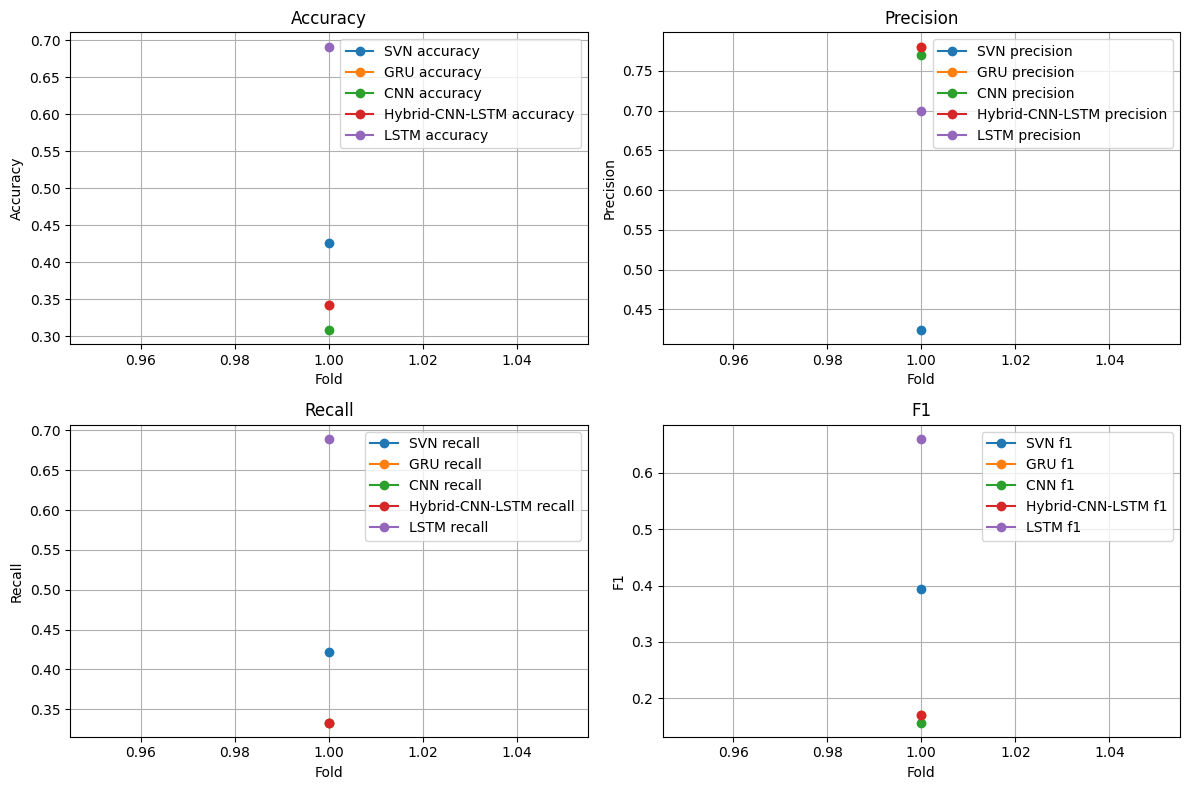

In [69]:
import matplotlib.pyplot as plt
model_names = list(results.keys())
metrics = ["accuracy", "precision", "recall", "f1"]

# สร้าง subplot
plt.figure(figsize=(12, 8))

# Plot แต่ละ metric
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    for model_name in model_names:
        plt.plot(range(1, len(results[model_name][metric]) + 1), results[model_name][metric], marker='o', label=f'{model_name} {metric}')
    plt.title(metric.capitalize())
    plt.xlabel('Fold')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

# แสดงผลกราฟ
plt.tight_layout()
plt.show()

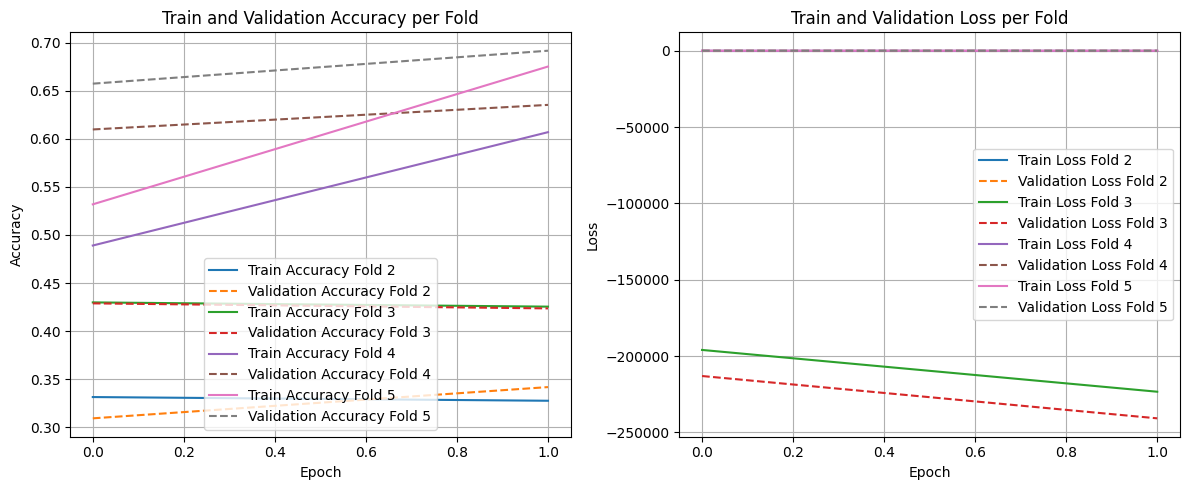

In [71]:
plt.figure(figsize=(12, 5))

# Plot Accuracy (Train vs Validation)
plt.subplot(1, 2, 1)
for fold_index in range(5):
    # Check if accuracy data exists for this fold
    if history_data['train_accuracy'][fold_index] is not None:
        plt.plot(history_data['train_accuracy'][fold_index], label=f'Train Accuracy Fold {fold_index + 1}')
    if history_data['val_accuracy'][fold_index] is not None:
        plt.plot(history_data['val_accuracy'][fold_index], label=f'Validation Accuracy Fold {fold_index + 1}', linestyle='--')

plt.title('Train and Validation Accuracy per Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss (Train vs Validation)
plt.subplot(1, 2, 2)
for fold_index in range(5):
    # Check if loss data exists for this fold
    if history_data['train_loss'][fold_index] is not None:
        plt.plot(history_data['train_loss'][fold_index], label=f'Train Loss Fold {fold_index + 1}')
    if history_data['val_loss'][fold_index] is not None:
        plt.plot(history_data['val_loss'][fold_index], label=f'Validation Loss Fold {fold_index + 1}', linestyle='--')

plt.title('Train and Validation Loss per Fold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
